In [20]:
%load_ext autoreload
%autoreload 1
%aimport AnalysisUtils
%aimport genCrossCor
%aimport genMapsfromCor
%aimport run_euclidlike_analysis
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot #to have two axis labels
import mpl_toolkits.axisartist as AA #to have two axis labels
from itertools import permutations, chain
from scipy.optimize import leastsq
from operator import itemgetter

In [22]:
import MapParams as mp
import CosmParams as cp #[NJW 160606]
import ClRunUtils as clu
import genCrossCor as gcc
import genMapsfromCor as gmc
import AnalysisUtils as au
import mapdef_utils as mdu
import run_euclidlike_analysis as runeuc
import time
import datetime
import healpy as hp
import os
import itertools
import copy

In [23]:
def getCombos(ls):
    """get list of tuples of all possible combinations of elements of input list ls"""
    a = []
    for L in range(0, len(ls)+1):
        for subset in itertools.combinations(ls, L):
            a.append(subset)
    return a[1:] #first element is blank tuple, so drop

def multi_depthtest_get_binmaps(z0vals=np.array([.3,.6,.7,.8]),includeisw=True, nbar='default'):
#    z0set = set(z0vals)
    tagend = ['']*len(z0vals) #ending to tack on to each survey tag -- default to nothing
#check for duplicates and append name. This is depreciated since duplicate z0 depths are now handled in get_rho and Cl_data object itself,
#which avoids having to duplicate Cl calulations as we would if renamed it at this point.
#     for i,z0 in enumerate(z0vals):
#         instance = (z0vals[:i]==z0).sum()+1 #what instance of z0 is this so far (e.g. "1" = for first 0.3)
#         if instance!= 1:
#             tagend[i] = "_v"+str(instance)
    if nbar!='default':
        surveys=[mdu.get_Euclidlike_SurveyType(z0=z0,onebin=True,nbar=nbar,tag='eucz{0:02d}'.format(int(10*z0))+tagend[i]) for i,z0 in enumerate(z0vals)]
    else: surveys=[mdu.get_Euclidlike_SurveyType(z0=z0,onebin=True,tag='eucz{0:02d}'.format(int(10*z0))+tagend[i]) for i,z0 in enumerate(z0vals)]
    bins=[s.binmaps[0] for s in surveys] #all surveys have only one bin
    if includeisw:
        iswmaptype=mdu.get_fullISW_MapType(zmax=15)
        iswbins=iswmaptype.binmaps
        bins=iswbins+bins
    return bins

def multi_get_Cl(justread=True,z0vals = np.array([.3,.6,.7,.8]),nbar='default', outtag=''): #[added outtag to allow easy spec of different output directory]
    bins=multi_depthtest_get_binmaps(z0vals, nbar=nbar)
    zmax=max(m.zmax for m in bins) #get highest max z of all the binmaps
    rundat = clu.ClRunData(tag='depthtest',rundir='output/'+outtag+'/',lmax=95,zmax=zmax) #keep info like lmax, output dir, tag, zmax, etc. and other general cl information we'll need for all maps
    return gcc.getCl(bins,rundat,dopairs=['all'],DoNotOverwrite=justread)

# same as depthtest_get_reclist, but don't define includeglm so uses all bins instead of limiting to the current bin (i.e. multisurvey)
def multi_depthtest_get_reclist(z0vals=np.array([.3,.6,.7,.8]), multi = False,nbar='default',minl_forrec=2):
    if multi == False:
        multi = range(z0vals) + [(0,1)]
    bins=multi_depthtest_get_binmaps(z0vals,nbar=nbar) #list of bins, since each map is only one bin for depth test
    binlist=[] #bins but without isw_bin0, so corresponds to input z0vals
    for b in bins:
        if b.tag!='isw_bin0':
            binlist.append([b])
        #print b.tag   #make list of lists, with each sublist a list of the bins in the map to use for recreation (only 1 each for now)
    Nrec = len(multi)
    reclist = [0]* Nrec
    for i,irec in enumerate(multi):
        includeglm=[]
        inmaptag = ''
        if type(irec) == int:
            irec = (irec,) #set to tuple so we can reuse upcoming for loop code
            mtag = ''
        else: mtag = '+'
        for m in irec: #for each survey in the list of surveys to use for recon
            for b in binlist[m]: #for each bin in the survey
                bintag=b.tag
                includeglm.append(bintag)
            inmaptag += mtag + bintag[:bintag.rfind('_bin')] #if single map, will be the standard bintag (without '_bin[X]'), if multi will be 'bintag0+bintag1'
        reclist[i] = au.RecData(includeglm=includeglm, inmaptag=inmaptag, minl_forrec=minl_forrec)
#         print (irec,includeglm, inmaptag)
    return reclist
def strp_str(bintag, to_strip='_bin0'):
    """strip '_bin0' from a bintag"""
    return bintag[:bintag.rfind(to_strip)]
def m_binarr_to_labels(maptags,to_strip='_bin0', to_add=''):
        """set [maptagA, maptagB,...] to 'maptagA+maptagB+...+maptagN', with to_strip (string) removed from end of each maptag and to_add appended to full label"""
        return '+'.join([strp_str(mt, to_strip=to_strip) for mt in maptags])+to_add

In [24]:
#use cldat to generate glm, alm, and maps; saves maps but not alm
#   does isw reconstruction automatically
def multi_depthtest_get_glm_and_rec(cldat=False, Nreal=1,z0vals=np.array([.3,.6,.7,.8]),minreal=0,justgetrho=0,dorell=0,dorho=1,dos=1,dochisq=1,dochisqell=0, multi=False, outtag='', nbar='default'):
    t0=time.time()
    if cldat==False:
        if multi==False:
            if nbar!='default': print "Warning, using default nbar instead of passed value!"
            cldat = depthtest_get_Cl(justread=True,z0vals=z0vals,outtag=outtag) #this isn't setup to take nbar yet
        else: cldat = multi_get_Cl(justread=True,z0vals=z0vals,outtag=outtag,nbar=nbar)
    makeplots=Nreal==1
    rlzns=np.arange(minreal,minreal+Nreal)
    if multi:
        reclist = multi_depthtest_get_reclist(z0vals, multi=multi) #try to use all the depth tests in recon
    else: reclist=runeuc.depthtest_get_reclist(z0vals)
    au.getmaps_fromCl(cldat,rlzns=rlzns,reclist=reclist,justgetrho=justgetrho,dorell=dorell,dorho=dorho,dos=dos,dochisq=dochisq,dochisqell=dochisqell)
    t1=time.time()
    print "total time for Nreal",Nreal,": ",t1-t0,'sec'
    
# get expectation values of rho or s, choose variable via varname
def multi_depthtest_get_expected_rho(cldat=False,reclist=False,z0vals=np.array([0.3,0.6,0.7,0.8]),nbar='default',varname='rho',outtag=''):
    if cldat==False: cldat=multi_get_Cl(justread=True, z0vals=z0vals, nbar=nbar, outtag=outtag)
    if reclist==False:
        multi = getCombos(range(len(z0vals))) #by default, get for all possible map combos
        reclist=multi_depthtest_get_reclist(z0vals=z0vals,multi=multi,nbar=nbar)
    rhopred=np.zeros_like(reclist)
    for i,rec in enumerate(reclist):
        rhopred[i] = au.compute_rho_fromcl(cldat,rec,varname=varname)
    return rhopred

def depthtest_get_expected_rell(z0vals=np.array([0.3,0.6,0.7,0.8]),varname='rell'):
    cldat=depthtest_get_Cl(z0vals=z0vals)
    reclist=depthtest_get_reclist(z0vals)
    rellpred=[]
    for i in xrange(z0vals.size):
        rellpred.append(au.compute_rell_fromcl(cldat,reclist[i],varname=varname))
    rellpred=np.array(rellpred)#[Nrec,Nell]
    #print rellpred
    return rellpred

class MRecStats(object):
    """Reconstruction info for multiple maps, e.g. net rho, s, etc. maptag_tuple must be subset of recdat.includeglm"""
    def __init__(self, cldat, recdat, lmin=2, lmax=-1, use_nbar_in_r=True): #calibstats, varlist=[0]
        self.maptags = recdat.includeglm
        self.cldat=cldat
        self.recdat=recdat
        self.indiv_reclist = [au.RecData(includeglm=[maptag]) for maptag in self.maptags]
#         print self.indiv_reclist[0].includeglm
        self.Nmaps = len(self.maptags)
#         self.Nvar = len(varlist)
        self.varlist=varlist #[0] by default (no calib errors)
        self.lmin = lmin
#         self.calibstats=calibstats
        
        if lmax==-1: self.lmax=cldat.Nell-1
        else: self.lmax=lmax
        self.nbar_in_rmap = use_nbar_in_r
        
        #calc ISW Recon stats
        #total <rho> for multimap recon (make sure calls right multi_get expected)
        self.rhoexp = multi_depthtest_get_expected_rho(cldat=self.cldat,reclist=(self.recdat,),varname='rho')[0]
        #array of rho for reconstructions using only the individual maps
        self.rho_arr = np.array([au.compute_rho_fromcl(self.cldat, rec1, varname='rho') for rec1 in self.indiv_reclist])
        #<rho_[AB...N]>/(<rho_A>*<rho_B>*...*<rho_N>)^(1/N)
        self.rho_rat = self.rhoexp/(self.rho_arr.prod())**(1./self.Nmaps)
        
        #s_isw
        self.sexp = multi_depthtest_get_expected_rho(cldat=self.cldat,reclist=(self.recdat,),varname='s')[0]
        self.s_arr = np.array([au.compute_rho_fromcl(self.cldat, rec1, varname='s') for rec1 in self.indiv_reclist])
        self.s_rat = self.sexp/(self.s_arr.prod())**(1./self.Nmaps)
        
        #rho_ell
        
        #calc map-to-map stats:
        self.rmaps=False
        self.rpairs=False
        self.rellmaps=False
        self.rellpairs=False
        self.calc_r(use_nbar=self.nbar_in_rmap)
#         self.label = False
        self.relabel()
        
    def relabel(self, to_strip='_bin0', to_add=''):
        """set self.label to 'maptagA+maptagB+...+maptagN', with to_strip (string) removed from end of each maptag and to_add appended to full label"""
        self.label = '+'.join([strp_str(mt, to_strip=to_strip) for mt in self.maptags])+to_add
        
    def calc_r(self, use_nbar):
        if self.Nmaps==2:
            #for only two maps, rmaps and rpairs are same
            self.rmaps = [au.get_r_for_maps(self.cldat,self.maptags[0],self.maptags[1], self.lmin, self.lmax,include_nbar=use_nbar)[0]]
            self.rpairs = self.rmaps[:] #need to slice, else will just reference rmaps array directly
            self.rellmaps = [au.get_r_for_maps(self.cldat,self.maptags[0],self.maptags[1], self.lmin, self.lmax,include_nbar=use_nbar)[1]]
            self.rellpairs = self.rellmaps[:]
        elif self.Nmaps==3: #rmaps has 
            r3_to_calc = [(1,2,0), (2,0,1), (0,1,2)] #third element in each tuple is map to add
            #[[(maptagB, maptagC), maptagA],[(maptagC,maptagA),maptagB], ...] #each element has info to create one r3
            mtuple_list = [[(self.maptags[t[0]], self.maptags[t[1]]), self.maptags[t[2]]] for t in r3_to_calc]
            #get multiple correlation coeff of one map with the other two [R_bc_a, R_ac_b, R_ab_c]
            self.rmaps = [au.get_r3_for_maps(self.cldat, m[0], m[1], self.lmin, self.lmax,include_nbar=use_nbar,tot_or_ell='tot')[0] for m in mtuple_list]
            #get pairwise correlations [r_ab, r_bc, r_ac]
            self.rpairs = au.get_r3_for_maps(self.cldat, mtuple_list[2][0], mtuple_list[2][1],self.lmin,self.lmax,include_nbar=use_nbar, tot_or_ell='tot')[1]
            self.rellmaps = [au.get_r3_for_maps(self.cldat, m[0], m[1], self.lmin, self.lmax, include_nbar=use_nbar, tot_or_ell='ell')[0] for m in mtuple_list]
            #get pairwise correlations by ell [rell_ab, rell_bc, rell_ac]
            self.rellpairs = au.get_r3_for_maps(self.cldat, mtuple_list[2][0], mtuple_list[2][1],self.lmin,self.lmax,include_nbar=use_nbar,tot_or_ell='ell')[1]

        elif self.Nmaps > 3: print "4+ maps in reconstruction -- can only compute r for up to 3 maps"

In [25]:


print cldat.Nmap
print cldat.crossinds[cl_dat.Nmap-1,cl_dat.Nmap-1]
print cldat.tagdict
print cldat.bintaglist
# xind=cldatdat.crossinds[2,2]
# xslice = [cldat.crossinds[i,1] for i in xrange(cld_dat.Nmaps)]
# print xslice
# print cldat.noisecl[:,1]

NameError: name 'cldat' is not defined

In [ ]:
# cl_dat2 = multi_get_Cl(justread=False,z0vals=depthtestz0, nbar=nbar, outtag=outtag)
# print cl_dat2.bintaglist
#cl_dat2.add_dupemap('eucz03_bin0')
#print cldat.docross
print m_binarr_to_labels(cldat.bintaglist)

In [26]:
outtag = 'depthtest_multi01'
st = time.time()
depthtestz0=np.array([.3,.5,.7,.9])
nbar = 'default'
#rho_AB/(rho_a*rho_b) vs. r_AB
cldat=multi_get_Cl(justread=True,z0vals=depthtestz0, nbar=nbar, outtag=outtag)
#doMulti = getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
doMulti2 = [0,1,2,3,(0,0),(1,1),(2,2),(3,3),(0,1),(0,2),(0,3),(1,2),(1,3),(2,3)] #getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
reclist = multi_depthtest_get_reclist(depthtestz0, multi=doMulti2, nbar=nbar)
mrs = [MRecStats(cldat, rec, use_nbar_in_r=True) for rec in reclist]
irs=[irec for irec in mrs if irec.Nmaps==1]#get the single reconstructions
mrs=[mrec for mrec in mrs if mrec.Nmaps>1]
mrs_noN = [MRecStats(cldat, rec, use_nbar_in_r=False) for rec in reclist]
irs_noN=[irec for irec in mrs_noN if irec.Nmaps==1]#get the single reconstructions
mrs_noN=[mrec for mrec in mrs_noN if mrec.Nmaps>1]

print "\nNmaps:",[recdat.Nmap for recdat in reclist]
print "\nMaps to include:\n",[recdat.includeglm for recdat in reclist]
# rhopred = multi_depthtest_get_expected_rho(cldat=cldat,reclist=reclist,varname='rho')
print cldat.bintaglist
print "Done! Minutes elapsed:",(time.time()-st)/60.

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Reading C_l file: output/depthtest_multi01/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.

Nmaps: [1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Maps to include:
[['eucz03_bin0'], ['eucz05_bin0'], ['eucz07_bin0'], ['eucz09_bin0'], ['eucz03_bin0', 'eucz03_bin0'], ['eucz05_bin0', 'eucz05_bin0'], ['eucz07_bin0', 'eucz07_bin0'], ['eucz09_bin0', 'eucz09_bin0'], ['eucz03_bin0', 'eucz05_bin0'], ['eucz03_bin0', 'eucz07_bin0'], ['eucz03_bin0', 'eucz09_bin0'], ['eucz05_bin0', 'eucz07_bin0'], ['eucz05_bin0', 'eucz09_bin0'], ['eucz07_bin0', 'eucz09_bin0']]
['isw_bin0', 'eucz03_bin0', 'eucz05_bin0', 'eucz07_bin0', 'eucz09_bin0']
Done! Minutes elapsed: 0.0110622326533


In [27]:
print '(mrs.maptags, mrs.rpairs[0], mrs.rhoexp, mrs.rho_arr, mrec.rmaps)'
for mrec in mrs:
    print (mrec.label, mrec.rpairs, mrec.rhoexp, list(mrec.rho_arr),mrec.rmaps)
for mrec in irs:
    print (mrec.label, mrec.rpairs, mrec.rhoexp, list(mrec.rho_arr),mrec.rmaps)

(mrs.maptags, mrs.rpairs[0], mrs.rhoexp, mrs.rho_arr, mrec.rmaps)
('eucz03+eucz03', [1.0], 0.66613578319765987, [0.66607551484611316, 0.66607551484611316], [1.0])
('eucz05+eucz05', [1.0], 0.85142960370209297, [0.85097910619297323, 0.85097910619297323], [1.0])
('eucz07+eucz07', [1.0], 0.92864620344671045, [0.92705662090902985, 0.92705662090902985], [1.0])
('eucz09+eucz09', [1.0], 0.94680877207764769, [0.94297374798989519, 0.94297374798989519], [1.0])
('eucz03+eucz05', [0.84084054660392871], 0.86934298124074161, [0.66607551484611316, 0.85097910619297323], [0.84084054660392871])
('eucz03+eucz07', [0.63337413676903809], 0.92757595155005257, [0.66607551484611316, 0.92705662090902985], [0.63337413676903809])
('eucz03+eucz09', [0.47777633765143629], 0.95638296037108317, [0.66607551484611316, 0.94297374798989519], [0.47777633765143629])
('eucz05+eucz07', [0.9245186456668063], 0.92908964889667878, [0.85097910619297323, 0.92705662090902985], [0.9245186456668063])
('eucz05+eucz09', [0.79455170955

In [28]:
def labplot_r(xr, yr, mlabels, xaxis='', yaxis='',show=True,ha='left',seq_label=''): #seqlabel is e.g. rho_ratio, vs mlabel is label for each multi-recon
    p = plt.plot(xr, yr, '.',label=seq_label)
    for label, x, y in zip(mlabels, xr, yr):
        plt.annotate(
            label, 
            xy = (x+0.01, y+0.0005), xytext = (20, 20),
            textcoords = 'offset points', ha = ha, va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.3),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.grid()
    if show: plt.show()
    else: return p
    
def labplot_s(xr, yr, mlabels, xaxis='', yaxis='',show=True,ha='right',seq_label=''):
    p = plt.plot(xr, yr, '.',label=seq_label)
    for label, x, y in zip(mlabels, xr, yr):
        plt.annotate(
            label, 
            xy = (x-0.005, y+0.005), xytext = (-20, 20),
            textcoords = 'offset points', ha = ha, va = 'bottom',
            bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.3),
            arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.grid()
    if show: plt.show()
    else: return p

In [29]:
def plotnfit(xarr, ytests, labels, deg=1, cmap='jet_r'):
    N = len(ytests)
    xtests=[xarr]*N
    cmap = plt.get_cmap(cmap)
    for i,(xarr,yarr,label) in enumerate(zip(xtests,ytests,labels)):
        color = cmap(float(i)/((2*N-1)))
        plt.plot(xarr,yarr,'o',label=label, color=color)
        coeffs = np.polyfit(xarr,yarr,deg=deg)
        if deg > 0:
            yfit = np.polyval(coeffs, np.sort(xarr)) #Evaluates the polynomial for each x2 value
            plt.plot(np.sort(xarr),yfit,'-',color=color)
    plt.grid()
    return
# labplot_r(x_rpairs,x_rho_rat,labels2,'r_map', 'rho_AB/sqrt(rhoA*rhoB)',show=False)
# plt.plot(x_rpairs_noN,x_rho_rat,'r.',label='No Noise')
rhomod1 = [mrec.rhoexp/np.max(mrec.rho_arr) for mrec in mrs]
rhomod2 = [mrec.rhoexp/np.min(mrec.rho_arr) for mrec in mrs]
labels22 = ['rho_rat (rho_AB/sqrt[rho_A*rho_B])','rho_AB/rho_best','rho_AB/rho_worst']

ytests = [x_rho_rat,rhomod1, rhomod2]
# for i,(yarr,label) in enumerate(zip(ytests,labels22)):
#     xarr = x_rpairs
#     color = cmap(float(i)/len(ytests))
#     plt.plot(xarr,yarr,'o',label=label, color=color)
#     coeffs = np.polyfit(xarr,yarr,deg=1)
#     yfit = np.polyval(coeffs, xarr) #Evaluates the polynomial for each x2 value
#     plt.plot(xarr,yfit,'-',color=color)
plotnfit(x_rpairs,ytests,labels22, deg=1)
plt.legend(loc='best')
# plt.xlim(.55,1.1)
# plt.ylim(.95,1.25)
plt.grid(True)
plt.title('Multi Recon Improvement over individual vs r_map')
plt.xlabel('r_maps')
plt.ylabel('dimless improvement vs. individual(see key)')
plt.show()

#s
smod1 = [mrec.sexp/np.min(mrec.s_arr) for mrec in mrs] #note that i switch min and max here since a low s corresponds to a higher rho, so dividing out same map.
smod2 = [mrec.sexp/np.max(mrec.s_arr) for mrec in mrs]

slabels= ['s_rat (s_AB/sqrt[s_A*rho_B])','s_AB/s_best','s_AB/s_worst']
ytests2 = [x_s_rat,smod1, smod2]
plotnfit(x_rpairs,ytests2,slabels, deg=1)
plt.legend(loc='best')
# plt.xlim(.55,1.1)
# plt.ylim(.95,1.25)
plt.grid(True)
plt.title('Multi Recon Improvement over individual vs r_map')
plt.xlabel('r_maps')
plt.ylabel('dimless improvement vs. individual(see key)')
plt.show()

NameError: name 'x_rho_rat' is not defined

In [30]:
labplot_s(x_rpairs, x_rhoexp, labels2, 'r_map','rho_AB',show=False)
for irec in irs:
    plt.plot(np.linspace(.4,1.1,10),[irec.rhoexp]*10,'--',label=irec.label)
plt.xlim(.4,1.1)
plt.legend(loc='best')
plt.show()
labplot_s(x_rpairs, x_sexp, labels2, 'r_map', 's_AB',show=False)
for irec in irs:
    plt.plot(np.linspace(.4,1.1,10),[irec.sexp]*10,'--',label=irec.label)
plt.show()
#labplot_r(mrecstats[0].rell, mrecstats[0].rhoell)

NameError: name 'x_rpairs' is not defined

In [31]:
def plot_mrslist(mrs, vartypes='rat',title=False, fitdeg=0, labplot=False): #vartype one of {'raw', rat', 'rat_best', 'rat_worst'}

    irs=[irec for irec in mrs if irec.Nmaps==1]#get the single reconstructions
    mrs=[mrec for mrec in mrs if mrec.Nmaps>1]

    x_rhoexp = [mrec.rhoexp for mrec in mrs]
    x_rho_rat = [mrec.rho_rat for mrec in mrs]
    x_sexp = [mrec.sexp for mrec in mrs]
    x_s_rat = [mrec.s_rat for mrec in mrs]
    x_ssymexp = [mrec.sexp for mrec in mrs]
    x_ssym_rat = [mrec.s_rat for mrec in mrs]

    x_rpairs = [mrec.rpairs[0] for mrec in mrs]
    mlabels2=[mrec.label for mrec in mrs]
    
    ylist=[]
    rhobest = [mrec.rhoexp/np.max(mrec.rho_arr) for mrec in mrs]
    rhoworst = [mrec.rhoexp/np.min(mrec.rho_arr) for mrec in mrs]
    labels22 = []
    
    slist=[]
    sbest = [mrec.rhoexp/np.max(mrec.rho_arr) for mrec in mrs]
    sworst = [mrec.rhoexp/np.min(mrec.rho_arr) for mrec in mrs]
    slabels22 = []
    if type(vartypes) == str: vartypes=[vartypes]
    if 'raw' in vartypes:
        ylist.append(x_rhoexp)
        labels22.append('rho_raw')
        slist.append(x_sexp)
        slabels22.append('s_raw')
    if 'rat' in vartypes:
        ylist.append(x_rho_rat)
        labels22.append('rho_rat')
        slist.append(x_s_rat)
        slabels22.append('s_rat')
    if 'rat_best' in vartypes:
        ylist.append(rhobest)
        labels22.append('rho_AB/rho_best') 
        slist.append(sbest)
        slabels22.append('s_AB/s_best') 
    if 'rat_worst' in vartypes:
        ylist.append(rhoworst)
        labels22.append('rho_AB/rho_worst')
        slist.append(sworst)
        slabels22.append('s_AB/s_worst')
    if labplot:
        N = len(ylist)
        for x,y,mlab,varlab in zip([x_rpairs]*N, ylist, [mlabels2]+['']*(N-1), labels22):
            labplot_r(x,y,mlab,'r_map', 'rho various',ha='left',show=False,seq_label=varlab)
            if title: plt.title(title)
            plt.legend(loc='best')
        plt.xlim(0.95*min(x_rpairs), 1.05*max(x_rpairs))
        plt.show()
        for x,y,mlab,varlab in zip([x_rpairs]*N, slist, [mlabels2]+['']*(N-1), slabels22):
            labplot_s(x,y,mlab,'r_map', 's various',ha='right',show=False,seq_label=varlab)
            plt.legend(loc='best')
        plt.xlim(0.95*min(x_rpairs), 1.05*max(x_rpairs))
        plt.show()
    else:
        plotnfit(x_rpairs, ylist, labels22, deg=fitdeg)
        if title:
            plt.title(title)
        plt.show()
    plt.legend(loc='best')
    print x_rpairs

In [32]:
def getShapeStr(lmin,lmax,width,shape='g'):
    if shape=='g':
        shapestr='g{2:d}_{0:d}l{1:d}'.format(lmin,lmax,int(width))
    elif shape=='l2':
        shapestr='l2_{0:d}l{1:d}'.format(lmin,lmax)
    return shapestr




def m_caltest_get_rhoexp(fidcl=False, z0_base=0.7,z0_sup=0.7,basevar=0,varlist=[1.e-4],lmax=30,lmin=0,shape='g',width=10.,
                         overwrite=False,doplot=True,saverho=True,varname='rho',filetag='',reclmin=1,
                         plotdir='output/m_caltest_plots/',nolmintag=False,dofidrec=False,nbar='default',outtag='',knowClCal=False, #if knowClCal=True, use recCl = true Cl (including ClCal) instead of fidCl
                         fitbias=True, get_Clfid=False,get_Clmod=False):
    """give z0_base and z0_sup, where the latter is the map to add to the first to see improvement and which gets the list of calib variances in varlist applied.
    basevar defines a calib error to apply to the basemap.
    Set z0_base = 0 to do recon with just one map"""
    #note this makes a parallel track for single map recon with caltest_get_rhoexp,
    #but would prefer not to edit guts of that one to, e.g. pass a Cl, as it also defines an output loc, etc. and don't want to risk
    #messing it up. It should be obvious from calc and output which way it was created, and this will allow comparison of the two methods.
    varlist=varlist[:] #was encountering some accidental changes to varlist outside function scope with fidrec. Make sure to pass a copy.
    dupesuf = '_sup' #if comparing two surveys of same depth, need two sets of Cls. The duplicate will be the "supplemental" map
    single_map=False
    if z0_base == False:
        single_map = True
    
    if single_map: z0_vals = [z0_sup] 
    else: z0_vals = [z0_base,z0_sup] #will need to change this is use multiple base bins
            
    fidbins=multi_depthtest_get_binmaps(z0_vals,nbar=nbar) #only need this to get the bin name, but now we're passing those in.
    lssbins=[fb.tag for fb in fidbins[1:]] #ignore the first entry (ISW)
    #fidcl=caltest_get_clfid(z0fid)
    #if z0_base == z0_sup, will use autopower, so pass set(z0_vals). If change to make z0_sup a list, will need to change this implementation
    if not fidcl:
        print 'No Cl object given. Calling multi_get_Cl...'
        fidcl=multi_get_Cl(justread=not(overwrite),z0vals=set(z0_vals), nbar=nbar, outtag=outtag)
        if not single_map:
            assert fidcl.clcomputed_forpair(lssbins[0],lssbins[1])
    else: fidcl=copy.deepcopy(fidcl)
    recdat = au.RecData(includeglm=lssbins,inmaptag=m_binarr_to_labels(lssbins),minl_forrec=reclmin)
    if len(set(z0_vals)) != len(z0_vals): #if there are duplicates, account for for this and change names accordingly
        fidcl,recdat = au.handle_dupes(fidcl, recdat, dupesuf=dupesuf)
        #lssbins[1] = lssbins[1]+dupesuf
        lssbins = recdat.includeglm
        assert [bn in fidcl.bintaglist for bn in lssbins] #verify all newly named lss bins are in bintaglist
    basebins = lssbins[:-1] #last entry is the map we're adding, assuming we already have the others (can't handle more than one base yet)
    supbin = lssbins[-1]

#     if saverho:
#         shapestr=getShapeStr(lmin=lmin,lmax=lmax,width=width,shape=shape)
#         outdir = 'output/'+outtag+'/m_caltest_plots/'
#         if filetag:
#             filetagstr='_'+filetag
#         else:
#             filetagstr=''
#         if not nolmintag: #for compatibility with older, pre-lmintest data
#             reclminstr="-lmin{0:02d}".format(reclmin)
#             filetagstr=filetagstr+reclminstr
#         datfile='m_caltest_'+'z{0:02d}+z{1:02d}_bvar{5:02e}_{2:s}_{3:s}exp{4:s}.dat'.format(z0_base,z0_sup,shapestr,
#                                                                                             varname,filetagstr,basevar)
#         if not overwrite and os.path.isfile(outdir+datfile): #file exists
#             print 'Reading data file:',datfile
#             x=np.loadtxt(outdir+datfile,skiprows=2)
#             invarlist=x[:,0]
#             if not np.all(invarlist==np.array(varlist)):
#                 print "WARNING, invarlist!=varlist, overwriting"
#             else:
#                 rhoarray=x[:,1]
#                 return rhoarray
#         else:
#             print 'Writing to data file:',datfile

    #construct map-mod combos for the variances given
    mapmods_sup=runeuc.caltest_getmapmods_onebin(supbin,varlist,lmax,lmin,shape,width)
#     print 'mapmods_sup:',mapmods_sup
    #generate calibration errors with fixed variance, spread through Cl lmin-lmax
    clmodlist=[]

#     print fidcl.bintaglist
#     print '\nfidcl supbin autopower l=0,5:  {0}, {1}'.format(fidcl.get_cl_from_pair(supbin,supbin,0),fidcl.get_cl_from_pair(supbin,supbin,5))
    if not single_map: #if we are using two or more maps for recon (set z0_base=False for only a single recon)
        assert len(basebins) == 1 #THIS ONLY WORKS FOR ONE MAP AS THE BASE MAP. NEED TO ADJUST IF USING MORE THAN ONE
        if type(basevar)==list: 
            assert len(basevar)==len(varlist), "variance of base map given as list length {0},\
                                                but must be same length as varlist for supplemental map ({1})".format(len(basevar),len(varlist))
            mapmods_base=runeuc.caltest_getmapmods_onebin(basebins[0],basevar,lmax,lmin,shape,width) #vary the basemap variance
            print 'Varying basemap variance along with sup-map variance'
        else: #do all calcs using same basevar
            mapmods_base=runeuc.caltest_getmapmods_onebin(basebins[0],[basevar]*len(varlist),lmax,lmin,shape,width) #mod to z0_base
        #for each variance, get calib error Cl
            #(note, this is an inefficient way to do this, since mm_base will be same everytime)
        for (mm_base, mm_sup) in zip(mapmods_base, mapmods_sup): #add calib errors according to (map, var[c]) for each base and sup maps
#             print 'INRHOEXP---modding Cl---',mm_sup
            clmod=gmc.apply_additive_caliberror_tocl(fidcl,[mm_base, mm_sup])
            clmodlist.append(clmod)
#             print 'clmod basebn autopower l=0,5:  {0}, {1}'.format(clmod.get_cl_from_pair(basebins[0],basebins[0],0),clmod.get_cl_from_pair(basebins[0],basebins[0],5))
#             print 'clmod supbin autopower l=0,5:  {0}, {1}'.format(clmod.get_cl_from_pair(supbin,supbin,0),clmod.get_cl_from_pair(supbin,supbin,5))
            
#         print 'mm_base,mm_sup[:5]=',zip(mapmods_base[:5], mapmods_sup[:5])
    else: #only single map, so only considering z0_sup map in recon
        for mm_sup in mapmods_sup: #add calib errors according to (map, var[c]) for sup maps
#             print 'INRHOEXP---modding Cl---',mm_sup
            clmod=gmc.apply_additive_caliberror_tocl(fidcl,[mm_sup])
#             print 'clmod supbin autopower l=0,4:  {0}, {1}'.format(clmod.get_cl_from_pair(supbin,supbin,0),clmod.get_cl_from_pair(supbin,supbin,4))
#             print 'clmod ISW-supbin crosspower [l=4]:  {0}'.format(clmod.get_cl_from_pair(fidbins[0].tag,supbin,4),)
            clmodlist.append(clmod) #<------ Clmod still good with autopowers, etc. Error must creep in later.
#         print 'mm_sup[::10]=',mapmods_sup[:10]

    # include fidicual cl as last entry
    if varlist[-1]!=0. and dofidrec:
#         print "  appending fiducial case, no calib error"
        varlist.append(0.)
        clmodlist.append(fidcl)
        
    # return array of shape [Nvar,Nell]
    Nrec=len(varlist)
#     rhoarray=np.zeros(Nrec)
    rho_list = [0]*Nrec
    for r in xrange(Nrec):
#         print '\n--ON VAR=',varlist[r],'---------'
        if knowClCal: recCl = clmodlist[r] #we know the calib errors and model them exactly
        else: recCl = fidcl #we don't know calib errors - use fiducial Cl
        rho_list[r]=au.compute_rho_fromcl(clmodlist[r],recdat,reccldat=recCl,varname=varname,fitbias=fitbias)
        if type(rho_list[r])==float:
            rhoarray=np.array(rho_list) #if varname is estop, we're getting the estimator operator instead of rho or s, so not a number and can't set array.
#         print 'fidcl tags:',fidcl.bintaglist
    #if save, write to file
    if saverho:
        f=open(outdir+datfile,'w')
        f.write('Multi calib error test: Clcal shape={0:s}, ell={1:d}-{2:d}, z0_base={3:.2d} (var(c)={4:.2e}), z0_sup={5:.2d}\n'.format(shape,lmin,lmax,z0_base,basevar,z0_sup))
        f.write('sup var(c(nhat))   <{0:s}>\n'.format(varname))
        f.write(''.join(['{0:.2e} {1:8.3f}\n'.format(varlist[i],rhoarray[i]) for i in xrange(Nrec)]))
        f.close()

    if doplot:
        runeuc.caltest_rhoexpplot(varlist,rhoarray,varname=varname,outtag=shapestr,plotdir=plotdir)
    result = [rho_list]
    if get_Clfid: result.append(fidcl)
    if get_Clmod: result.append(clmodlist)
    if len(result) > 1: return result
    else: return result[0] #if only rho_list, return rho_list straight instead of nested in another list
####--------- cell 2

In [33]:
def calplotsetup(fig=False,size=(7,4)):
    """call before calplotform to setup figure and axis. Plot desired lines between the two function calls via ax1.plot(...)."""
    if not fig:
        fig=plt.figure(figsize=size)
        fig.subplots_adjust(bottom=.2)
        fig.subplots_adjust(left=.175)
        fig.subplots_adjust(right=.95)
    ax1 = plt.subplot()
    return (fig,ax1)

def calplotform(axis, varname='rho',show=False, showregions=True, xlabel=r'Var[c]'):
    """Pass axis, format like caltest rho and s plots in paper. Plot actual curves explicitly then call this. showregions bool toggles the shaded 'current' and 'future' regions"""
    ax1 = axis
    #--- resume plotting details
#     linelabel='Theory (add. only)'
    for item in ([ax1.xaxis.label, ax1.yaxis.label] + ax1.get_xticklabels()
                  + ax1.get_yticklabels()):
        item.set_fontsize(18)
    for item in ([ax1.yaxis.label]):
        item.set_fontsize(24)#(22)
    plt.sca(ax1)
    ax1.grid(True)
    ax1.set_xscale('log')
    ax1.set_xlim((10**-8,10**-1.5))#(10**-7.5,10**-1.5))
#     ax1.set_xlabel(r'Variance of calib. error field ${\rm var}[c]$')
    ax1.set_xlabel(xlabel)
    ax1.axhline(0,color='grey',linestyle='-')
    if varname=='rho':
        ax1.set_ylim(0,1)#(-.3,1.3)
        ax1.axhline(1,color='grey',linestyle='-')
        ax1.set_ylabel(r'$\rho$')
    elif varname=='s':
        ax1.set_ylabel(r'$s$')
        ax1.set_ylim((.1,3.))

    if showregions:
        #fill in regions for current/future values
        nowmin=1.e-4
        nowmax=1.e-3
        nowcenter=10**(.5*(np.log10(nowmin)+np.log10(nowmax)))
        nowlabel='current'
        nowcol='#377eb8'
        futuremin=1.e-6
        futuremax=1.e-5
        futurecenter=10**(.5*(np.log10(futuremin)+np.log10(futuremax)))
        futurelabel='future'
        futurecol='#4daf4a'
        ymin,ymax=ax1.get_ylim()
        ##plt.fill_between(varlist[:-1],ymin,ymax, facecolor=nowcol,edgecolor='none',linewidth=2, alpha=0.3)
        ax1.axvspan(nowmin,nowmax,alpha=0.1,color=nowcol)
        plt.annotate(nowlabel,xy=(nowcenter,ymin),horizontalalignment='center',verticalalignment='bottom',fontsize=16,color=nowcol)
        ax1.axvspan(futuremin,futuremax,alpha=0.1,color=futurecol)
        plt.annotate(futurelabel,xy=(futurecenter,ymin),horizontalalignment='center',verticalalignment='bottom',fontsize=16,color=futurecol)

    ##data points should just have one entry, but copying whole mess anyway
    # for i in xrange(len(datplot)):
    #     datvar=datplot[i][0]#array
    #     datrho=datplot[i][1]#array
    #     datlabel=datplot[i][2] #string
    #     datNreal=0
    #     datcol=datplot[i][3]
    #     datsig=datplot[i][4]         
    #     datrefmean=datplot[i][5]
    #     if len(datplot[i])>5:
    #         datNreal=datplot[i][6]
    #     if not datcol:
    #         datcol=colorlist[0]
    #     ax1.errorbar(datvar,datrho,yerr=datsig,label=datlabel,color=datcol,linestyle='None',marker='o')    

    plt.sca(ax1)
    if varname=='rho':
        plt.legend(fontsize=12,loc='upper right',numpoints=1)
    elif varname=='s':
        plt.legend(fontsize=12,loc='upper left',numpoints=1)

    # print 'Saving plot to ',plotdir+outname
    # plt.savefig(plotdir+outname)
    # plt.close()
    if show: plt.show
    return ax1

In [34]:
class CalibSpecs(object):
    def __init__(self,shape='g', width=10.,lmincal=0,lmaxcal=30):
        self.shape=shape
        self.width=width
        self.lmincal=lmincal
        self.lmaxcal=lmaxcal

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Reading C_l file: output/mCal04_fidz0_bv0/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.

-----z0_base=0.3, z0_sup=0.5-----
Varying basemap variance along with sup-map variance


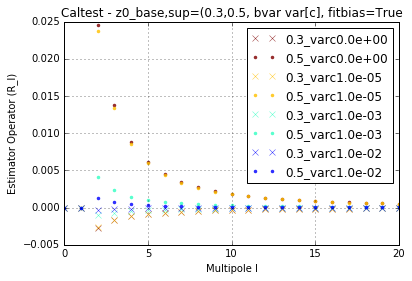


-----z0_base=0.5, z0_sup=0.7-----
Varying basemap variance along with sup-map variance


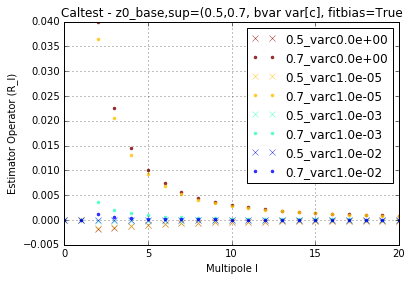


-----z0_base=0.3, z0_sup=0.7-----
Varying basemap variance along with sup-map variance


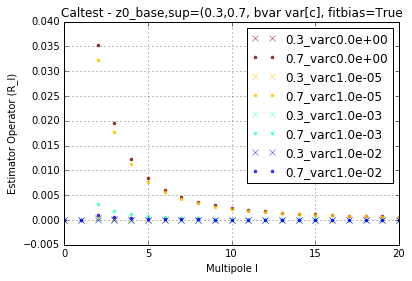


-----z0_base=0.3, z0_sup=0.5-----
Varying basemap variance along with sup-map variance


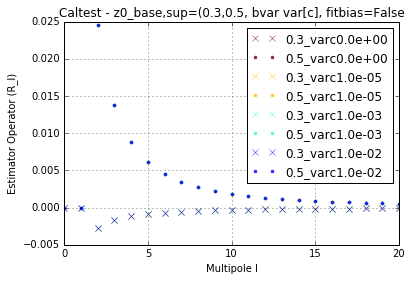


-----z0_base=0.5, z0_sup=0.7-----
Varying basemap variance along with sup-map variance


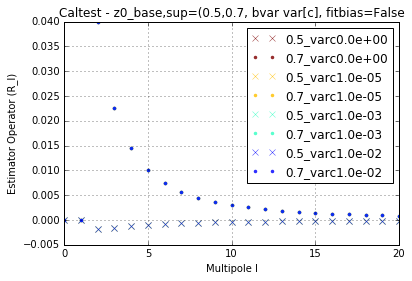


-----z0_base=0.3, z0_sup=0.7-----
Varying basemap variance along with sup-map variance


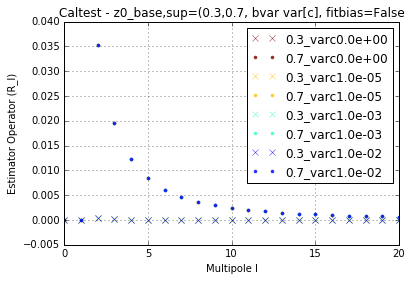


-----z0_base=0.3, z0_sup=0.5-----

-----z0_base=0.5, z0_sup=0.7-----

-----z0_base=0.3, z0_sup=0.7-----


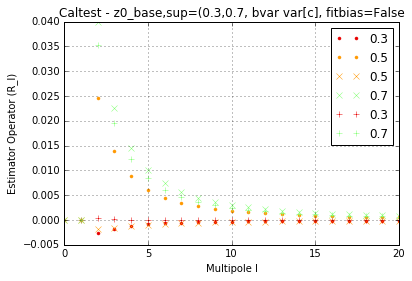

In [35]:

nbar='default'
z0pairs=[(.3,.5),(.5,.7),(.3,.7)]
#Cal test Multi:
#==========================================
# v v v----- This function (caltest_basic_expplot_forpaper) is from GPFP module. Using to guide mu
# plots rho exp and data points for one shape and lmin
#combine stuff from caltest_compare_clcal_shapes with rhoexpplot
outtag='mCal04_fidz0_bv0'
colorlist=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']#qualitative
reclmin=2
#info about calibration errors
# calspecs = CalibSpecs(shape='g',width=10.,lmincal=0,lmaxcal=30)
(shape,width,lmincal,lmaxcal)=('g',10.,0,30)

#what points to plot
shortvarlist=[0,1.e-5,1.e-3,1.e-2]#for data points
varlist=shortvarlist[:]
basevar=shortvarlist[:]
cmap = plt.get_cmap('jet_r')
N_var=len(varlist)
scalebycl = True
z0set = set(chain.from_iterable(z0pairs))

fidcl=multi_get_Cl(justread=True,z0vals=z0set, nbar=nbar, outtag=outtag)
for fitbias in (True, False):
#     fig, ax1 = calplotsetup()
    for k,(z0_1,z0_2) in enumerate(z0pairs):
        print '\n-----z0_base={0}, z0_sup={1}-----'.format(z0_1,z0_2)

        (estop_list_temp,fidcl,clmod) = m_caltest_get_rhoexp(fidcl, z0_base=z0_1, z0_sup=z0_2, basevar=basevar[:],varlist = varlist[:],lmax=lmaxcal,lmin=lmincal,
                                shape=shape,width=width,overwrite=False,doplot=False,saverho=False,varname='estop',
                                reclmin=reclmin,outtag=outtag,fitbias=fitbias,get_Clfid=True,get_Clmod=True)
#         estop_array = np.array(estop_list_temp)
#         relweights = np.zeros_like(estop_array) #inprog. For looking at the weights of maps vs l 
        for j,estop_var in enumerate(estop_list_temp):#list of length varlist
            color = cmap(float(j)/((1.1*N_var-1)))
            #estimator operator, shape (NLSS,Nell), where Nell is highest l value i think
            l_x = xrange(estop_var.shape[1])
            for i,R_l_list in enumerate(estop_var): #NLSS is 2 right now, since recdat uses z0_1 and z0_2 as its two input maps
                if i==0: pt = 'x'
                else: pt = '.'
                plt.plot(l_x, R_l_list,pt,color=color, alpha=.8,label='{0:.1}_varc{1:.1e}'.format(z0pairs[k][i],varlist[j]))
    #     ax1=calplotform(ax1,varname=varname) #format like caltest plot
        if basevar==varlist: bvlabel = 'var[c]'
        else: bvlabel='{0}'.format(basevar,)
        # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
        plt.xlabel('Multipole l')
        plt.ylabel('Estimator Operator (R_l)')
        plt.xlim(0,20)
        plt.grid(True)
        plt.legend()
        plt.title('Caltest - z0_base,sup=({0:.1f},{3:.1f}, bvar {1}, fitbias={2}'.format(z0_1,bvlabel,fitbias,z0_2))
        plt.show()
#         plt.plot(l_x,estop_var/)

#When fitbias = False, estop is same for all var_c. So look at relative combos
mrk_list=['.','x','+']
z0_set=set([])
for k,(z0_1,z0_2) in enumerate(z0pairs):
    print '\n-----z0_base={0}, z0_sup={1}-----'.format(z0_1,z0_2)
    estop_list_temp = m_caltest_get_rhoexp(fidcl, z0_base=z0_1, z0_sup=z0_2, basevar=0,varlist = [0],lmax=lmaxcal,lmin=lmincal,
                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='estop',
                            reclmin=reclmin,outtag=outtag,fitbias=fitbias)
    estop_var=estop_list_temp[0]
    #estimator operator, shape (NLSS,Nell), where Nell is highest l value (pretty sure)
    l_x = xrange(estop_var.shape[1])
    for i,R_l_list in enumerate(estop_var): #NLSS is 2 right now, since recdat uses z0_1 and z0_2 as its two input maps
        color = cmap(z0pairs[k][i]**2) #each z0 has same color, marker dependent on which other map is paired with
        plt.plot(l_x, R_l_list,mrk_list[k],color=color,label='{0:.1}'.format(z0pairs[k][i],))
#     ax1=calplotform(ax1,varname=varname) #format like caltest plot
    if basevar==varlist: bvlabel = 'var[c]'
    else: bvlabel='{0}'.format(basevar,)
    # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
plt.xlabel('Multipole l')
plt.ylabel('Estimator Operator (R_l)')
plt.xlim(0,20)
plt.grid(True)
plt.legend()
plt.title('Caltest - z0_base,sup=({0:.1f},{3:.1f}, bvar {1}, fitbias={2}'.format(z0_1,bvlabel,fitbias,z0_2))
plt.show()



kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= False
Reading C_l file: output/depthtest/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


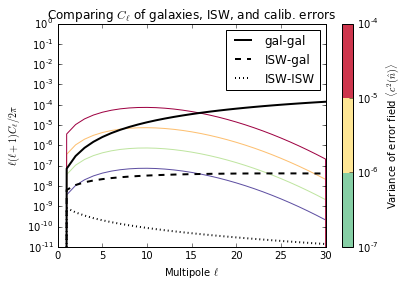

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


/Users/nw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: divide by zero encountered in divide
/Users/nw/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in divide


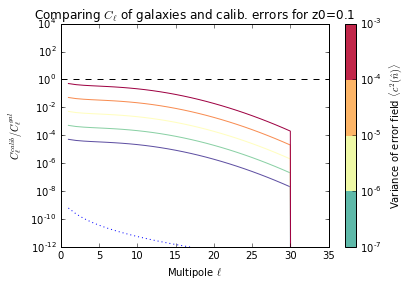

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


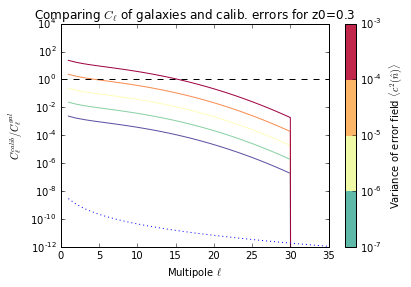

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


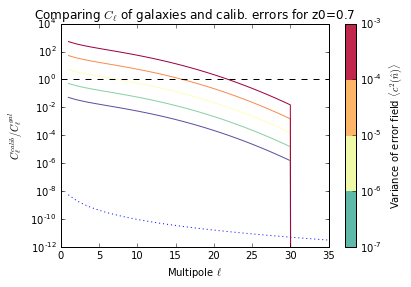

In [37]:
runeuc.caltest_Clcomp()

# this from run_euclid. Adapt to multi, generic z0 to look at noise vs signal Cl.
#---------------------------------------------------------------
# plot comparison bewteen Cl cal and Cl gal or Cl gal-ISW to understand
# why the transition in rho happens where it is
def mcaltest_Clcomp(z0,varlist=[1.e-7,1.e-6,1.e-5,1.e-4,1.e-3],shape='g',callmin=0,callmax=30,width=10.,
                    plotdir='output/caltest_plots/',saveplot=False, relative=False, outtag='mCal_full00'):
    Nvar=len(varlist)
    #get Clcal and Cl
    fidbins=runeuc.caltest_get_fidbins(z0)
    iswbin=fidbins[0].tag #will be the isw map
    iswind=0
    lssbin=fidbins[1].tag #will just be the depthtest bin map
    lssind=1
#     fidcl=runeuc.caltest_get_clfid(z0)
    fidcl=multi_get_Cl(justread=True, z0vals=[z0], outtag=outtag)
    l=np.arange(fidcl.Nell)
    
    #construct map-mod combos for the variances given
    mapmods=runeuc.caltest_getmapmods_onebin(lssbin,varlist,callmax,callmin,shape,width)
    clcal=np.zeros((Nvar,fidcl.Nell))
    for i in xrange(Nvar):
        ctag=mapmods[i][1]
        if ctag[:2]=='l2':#power law
            var,maxl,minl=gmc.parsemodtag_fixedvar_l2(ctag)
            thiscalcl=gmc.gen_error_cl_fixedvar_l2(var,maxl,minl)
        elif ctag[:1]=='g':#gaussian
            var,maxl,minl,width=gmc.parsemodtag_fixedvar_gauss(ctag)
            thiscalcl=gmc.gen_error_cl_fixedvar_gauss(var,maxl,minl,width=width)
        clcal[i,:callmax+1]=thiscalcl
        
    #plot Cl cal for various variance values in color gradient
    # http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
    cm=plt.get_cmap('Spectral_r')
    cNorm=runeuc.colors.LogNorm()#max and min numbers colors need to span
    scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm)
    varcols=scalarMap.to_rgba(varlist)
    clscaling=l*(l+1.)/(2*np.pi)
    #to get colorbar key, need ot set up a throw-away map
    dummyz=[[0,0],[0,0]]
    dummylevels=varlist
    dummyplot=plt.contourf(dummyz,dummylevels,cmap=cm,norm=cNorm)
    plt.clf()
    fig=plt.gcf()
    
    fig=plt.figure(0)
    ax=plt.subplot()

    if relative:
        plt.ylabel(r'$C_{{\ell}}^{calib}/C_{{\ell}}^{gal}$')
    else: plt.ylabel(r'$\ell(\ell+1)C_{{\ell}}/2\pi$')
             
    #plto fid cl
    #overlay Clgal, Clgal-isw in bolded lines
    lssauto=fidcl.crossinds[lssind,lssind]
    lssisw=fidcl.crossinds[iswind,lssind]
    iswauto=fidcl.crossinds[iswind,iswind]

    if not relative:
        line1,=plt.plot(l,np.fabs(fidcl.cl[lssauto,:])*clscaling,color='black',linestyle='-',linewidth=2,label='gal-gal')
        line2,=plt.plot(l,np.fabs(fidcl.cl[lssisw,:])*clscaling,color='black',linestyle='--',linewidth=2,label='ISW-gal')
        line3,=plt.plot(l,np.fabs(fidcl.cl[iswauto,:])*clscaling,color='black',linestyle=':',linewidth=2,label='ISW-ISW')
        for i in xrange(Nvar):
            plt.plot(l,np.fabs(clcal[i,:])*clscaling,color=varcols[i])
        plt.legend(handles=[line1,line2,line3])
        
        plt.title(r'Comparing $C_{{\ell}}$ of galaxies, ISW, and calib. errors')
        plt.ylim((1.e-11,1.))
    else:
        for i in xrange(Nvar):
            plt.plot(l,clcal[i,:]/fidcl.cl[lssauto,:],color=varcols[i])
#             print fidcl.cl[lssauto,:]
        plt.plot(l,[1]*len(l),'k--')
        plt.plot(l, fidcl.cl[lssisw,:]**2/fidcl.cl[lssauto,:]*(2.*l+1),':')
        plt.title(r'Comparing $C_{{\ell}}$ of galaxies and calib. errors for z0={0}'.format(z0,))
    plt.xlabel(r'Multipole $\ell$')
    plt.xlim((0,35))
    plt.yscale('log')
    plt.ylim((10**-12,10**4))
    #set up colorbar
    logminvar=int(np.log10(min(varlist)))
    logmaxvar=int(np.log10(max(varlist)))+1
    Nlog=logmaxvar-logminvar
    varticks=[10**(logminvar+n) for n in xrange(Nlog)]
    #cbaxes=fig.add_axes([.8,.1,.03,.8])#controls location of colorbar
    colbar=fig.colorbar(dummyplot,ticks=varticks)
    colbar.set_label(r'Variance of error field $\langle c^2(\hat{{n}})\rangle$')
    
    #get legend entry for Clcal
    #cal_patch = mpatches.Patch( color='red',label='cal. error')
    plt.show()
    
    plotname='caltest_cl_compare'
    outname=plotdir+plotname+'.pdf'
    if saveplot:
        print 'saving',outname
        plt.savefig(outname)
        plt.close()
    return fig
f1=mcaltest_Clcomp(.1,relative=True)
f1=mcaltest_Clcomp(.3,relative=True)
f2=mcaltest_Clcomp(.7,relative=True)


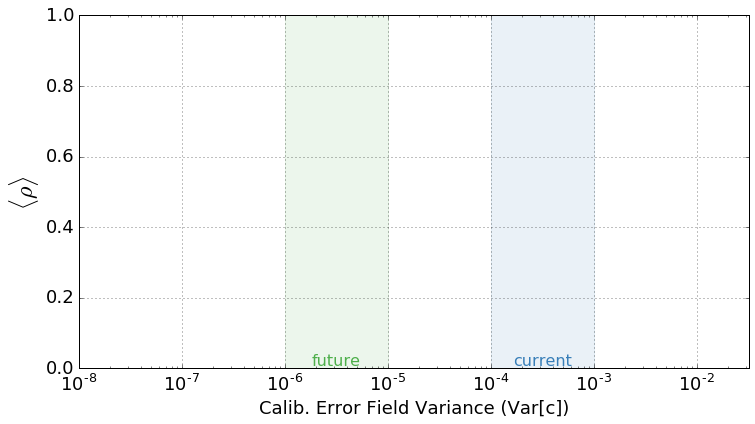

In [38]:
z0_base=0.7
fibias=True
z0_sup = 0.7
nbar='default'
z0list_toplot=[.1,.2,.3,.4,.5,.7,.9]#,1.3,1.5]#[.3,.4,.5,.6,.7,.8,.9]
outtag='mCal_full00'
varname = 'rho'
#what points to plot
varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=100,Nperlog=10))
basevar=varlist[:]

# rhoexplist_indiv_sup = runeuc.caltest_get_rhoexp(z0=z0_sup,varlist=varlist,lmax=lmaxcal,lmin=lmincal,shape=shape,width=width,
#                                                  overwrite=False,doplot=False,saverho=False,varname=varname,reclmin=reclmin)
# rhoexplist_indiv_base = runeuc.caltest_get_rhoexp(z0=z0_base,varlist=varlist,lmax=lmaxcal,lmin=lmincal,shape=shape,width=width,
#                                                   overwrite=False, doplot=False,saverho=False,varname=varname,reclmin=reclmin)
#rhoexplist_indiv_sup = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0_sup, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='rho',
#                                 reclmin=reclmin,outtag=outtag)
# sexplist_indiv_sup = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0_sup, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='s',
#                                 reclmin=reclmin,outtag=outtag)

# sexplist_indiv_base = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0_base, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='s',
#                                 reclmin=reclmin,outtag=outtag)
#-----


# print '\n ------ add varying supmap to base map with constant basevar'
# rhoexplist=m_caltest_get_rhoexp(z0_base=z0_base,z0_sup=z0_sup,basevar=basevar,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
#                                 reclmin=reclmin,outtag=outtag, fitbias=fitbias)

# #set basevar = var[c] as well, so both maps same variance
# rhoexplist2=m_caltest_get_rhoexp(z0_base=z0_base,z0_sup=z0_sup,basevar=varlist,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
#                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
#                                 reclmin=reclmin,outtag=outtag)
# #----
#get data
##shapestr=r'$C_{{\ell}}^{{\rm cal}}\propto e^{{-(\ell/{0:.0f})^2}}$'.format(width,lmincal,lmaxcal)

#datplot=caltest_getdataplot_forshapecompare(varname,shortvarlist,[shape],[width],[lmincal],[lmaxcal],recminelllist=np.array([reclmin]),colorlist=colorlist,labellist=['Results from sim.'],getunmod=False)
#setting getunmod=false since we don't need cal=0 reference means

#do plotting!
#assuming last entry in varlist, rhoarray is fiducial (var=0)

for fitbias in [True]:#, False]:
    fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
    ltypes=('-','--',':')
    for i,reclmin in enumerate([2]):
        lt = ltypes[i]
        #theory line
        # ax1.plot(varlist[:-1],rhoexplist[:-1],'--',label='Base+Sup')#linelabel,color=colorlist[1])
        # ax1.plot(varlist[:-1],rhoexplist2[:-1],'--',label='Base+Sup, vary Basevar')#linelabel,color=colorlist[1])
        # ax1.plot(varlist[:-1],rhoexplist[:-1],'--',label='Base+Sup')#linelabel,color=colorlist[1])
        # ax1.plot(varlist[:-1],rhoexplist2[:-1],'--',label='Base+Sup, vary Basevar')#linelabel,color=colorlist[1])

        #double z0 vs var[c] plot
        if 0:
            print '\n----- double z0 vs var[c]'
            for z0 in z0list_toplot:
                rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0, z0_sup=z0, basevar=varlist[:],varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag,fitbias=fitbias)
                ax1.plot(varlist[:-1],rhoexp_temp[:-1],'-',alpha=0.8,label='{0} + {1}'.format(z0,z0))
        # z0_base + many z0_sup vs var[c]
        if 0:
            print 'z0 vs var[c]'
            for z0 in z0list_toplot:
                rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0, basevar=basevar,varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag,fitbias=fitbias)
                ax1.plot(varlist[:-1],rhoexp_temp[:-1],'-',alpha=0.8,label='{0} + {1}'.format(z0,z0_base))


    #    single z0 vs var[c] for many z0
        if 0:
            for z0 in z0list_toplot:
                rhoexp_temp = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag)
                ax1.plot(varlist[:-1],rhoexp_temp[:-1],lt,label='$z_0={0},lmin={1}$'.format(z0,reclmin))

    #         plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))
    

        if 0: #single z0 vs var[c] for just z0_base
            print '\n----SINGLE, vary z0_base by var[c]'
            rhoexplist_indiv_base = m_caltest_get_rhoexp(z0_base=False, z0_sup=z0_base, basevar=False,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag, fitbias=fibias)
            ax1.plot(varlist[:-1],rhoexplist_indiv_base[:-1],'--',label='{0} single'.format(z0_base,))#,color=colorlist[2])
        # #two sup maps, each with var[c]
        if 0:
            rhoexplist_2sup=m_caltest_get_rhoexp(z0_base=z0_sup, z0_sup=z0_sup, basevar=varlist[:],varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                        shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                        reclmin=reclmin,outtag=outtag)
            ax1.plot(varlist[:-1],rhoexplist_2sup[:-1],'--',label='{0}_double'.format(z0_sup,),alpha=.5)#,color=colorlist[0])

        # #two base maps, each with var[c]
        if 0:
            rhoexplist_2base=m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0_base, basevar=varlist,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                            shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                            reclmin=reclmin,outtag=outtag, fitbias=fitbias)
            ax1.plot(varlist[:-1],rhoexplist_2base[:-1],'--',label='{0}_double'.format(z0_base,),alpha=.5)#,color=colorlist[0])
            # ax1.plot(varlist[:-1],rhoexplist_2base[:-1],'.-',label='base_dubs',color=colorlist[2])

        # ax1.plot(varlist[:-1],rhoexplist_indiv_sup[:-1],'--',label='{0} single'.format(z0_sup,))#,color=colorlist[0])
        # ax1.plot(varlist[:-1],[rhoexplist[-1]]*len(varlist[:-1]),'--',label='Sup_fid',color=colorlist[0])

    #     ax1.plot(varlist[:-1],rhoexplist_indiv_base[:-1],'--',label='{0} single'.format(z0_base,))#,color=colorlist[2])
        # ax1.plot(varlist[:-1],[rhoexplist_indiv_base[-1]]*len(varlist[:-1]),'--',label='Base_fid',color=colorlist[2])

    ax1=calplotform(ax1,varname=varname) #format like caltest plot
    if varname=='rho':
        ax1.set_ylabel(r'$\langle\rho\rangle$')
    elif varname=='s':
        ax1.set_ylabel(r'$\langle s\rangle$')
    ax1.set_xlabel(r'Calib. Error Field Variance (Var[c])')
    if basevar==varlist: bvlabel = 'var[c]'
    else: bvlabel='{0}'.format(basevar,)
    # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
#     plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))
#     plt.xlim(10.e-8,1e-2)
#     plt.ylim(-1,1)
    plotdir="/Users/nw/Desktop/plots/"#output/"+outtag+"/plots_forpaper/"
    dt = datetime.datetime.now()
    ts = '{0}{1:02d}{2:02d}_{3:02d}{4:02d}{5:02d}'.format(dt.year%2000,dt.month,dt.day,dt.hour,dt.minute,dt.second) #YYMMDDHHMM
    outname=ts+'_cal_{0}.pdf'.format(varname,)
#     print 'Saving plot to ',plotdir+outname
#     plt.savefig(plotdir+outname,dpi=300)
    plt.show()

    # # plot s
    # #plot 2 map recons
    # fig, ax1 = calplotsetup()

    # #double z0 vs var[c]
    # for z0 in z0list_toplot:
    #     rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0, basevar=basevar,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
    #                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='s',
    #                                 reclmin=reclmin,outtag=outtag)
    #     ax1.plot(varlist[:-1],rhoexp_temp[:-1],'-',label='{0}'.format(z0))

    # ax1.plot(varlist[:-1],sexplist_indiv_base[:-1],'--',label='{0} single'.format(z0_base,),alpha=.5)#,color=colorlist[0])
    # ax1=calplotform(ax1,varname='s') #format like caltest plot
    # plt.title('Caltest - z0_base {0:.1f}, bvar {1}'.format(z0_base,bvlabel))
    # plt.show()

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Reading C_l file: output/mCal04_fidz0_bv0/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
set([0.5, 0.7, 0.9])
[[ 0.          0.          1.          1.        ]
 [ 0.99607843  0.          0.00392157  1.        ]
 [ 0.          1.          0.          1.        ]]

-----z0_base=0.5, z0_sup=0.7-----
Varying basemap variance along with sup-map variance

-----z0_base=0.7, z0_sup=0.7-----
Varying basemap variance along with sup-map variance

-----z0_base=0.9, z0_sup=0.7-----
Varying basemap variance along with sup-map variance


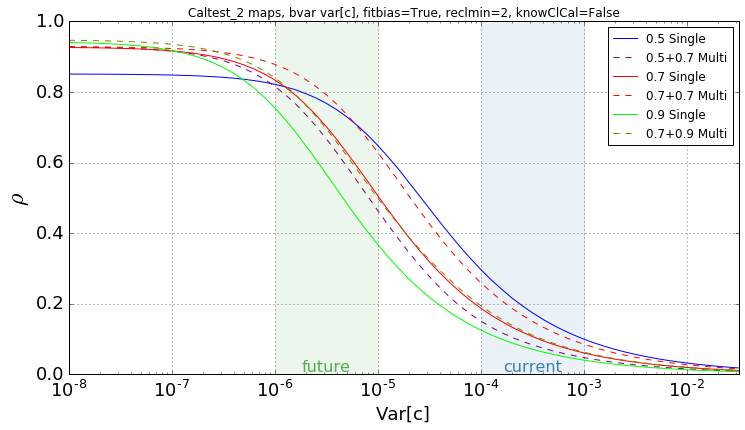


-----z0_base=0.5, z0_sup=0.7-----
Varying basemap variance along with sup-map variance

-----z0_base=0.7, z0_sup=0.7-----
Varying basemap variance along with sup-map variance

-----z0_base=0.9, z0_sup=0.7-----
Varying basemap variance along with sup-map variance


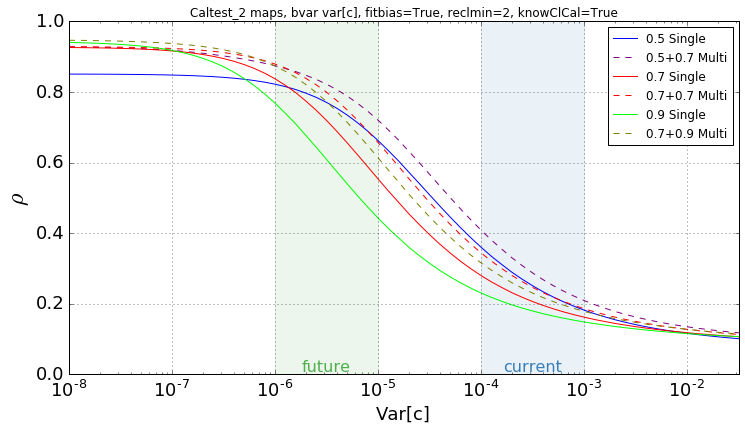

In [74]:
#plot various map pairs
reclmin=2
nbar='default'
z0pairs=[(.5,.7),(.7,.7),(.9,.7)]
outtag='mCal04_fidz0_bv0'
plotdir='output/'+outtag+'/plots_forpaper/'

#def caltest_basic_expplot_forpaper(varname='rho',plotdir='output/plots_forpaper/'):

#outname='caltest_'+varname+'_exp_test.pdf'
colorlist=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']#qualitative
reclmin=2
#info about calibration errors
shape='g'
width=10.
lmincal=0#min ell for calib error
lmaxcal=30#max ell for caliberror

#what points to plot
varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=100,Nperlog=10))
shortvarlist=[1.e-7,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2]#for data points
basevar=varlist[:]
rhoexplist=[]#will be 1D; [variance ] 
# knowClCal = True

z0set = set(chain.from_iterable(z0pairs))
z0max = max(z0set)
fidcl=multi_get_Cl(justread=True,z0vals=z0set, nbar=nbar, outtag=outtag)
cm=plt.get_cmap('brg')#Spectral_r')
cNorm=runeuc.colors.Normalize()#max and min numbers colors need to span
scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
z0cols=scalarMap.to_rgba(list(z0set)) #need to do this, even though don't call z0cols, else they all turn out the same color
print z0set
print z0cols
for varname in ['rho']:
    outname='caltest_'+varname+'_exp_basic.pdf'
    fitbias=True
#     for fitbias in (True, False):
    for knowClCal in (False, True):
        fig, ax1 = calplotsetup(size=(12,7))
        for (z0_1,z0_2) in z0pairs:
            print '\n-----z0_base={0}, z0_sup={1}-----'.format(z0_1,z0_2)
            exp_temp = m_caltest_get_rhoexp(fidcl, z0_base=z0_1, z0_sup=z0_2, basevar=basevar,varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                        shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                        reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)  
            exp_temp_sing1 = m_caltest_get_rhoexp(fidcl, z0_base=False, z0_sup=z0_1, basevar=False,varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                        shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                        reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
            exp_temp_sing2 = m_caltest_get_rhoexp(fidcl, z0_base=False, z0_sup=z0_2, basevar=False,varlist=varlist[:],lmax=lmaxcal,lmin=lmincal,
                                        shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                        reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
#             print z0_1
            my1col=scalarMap.to_rgba(z0_1)
#             print my1col
            my2col=scalarMap.to_rgba((z0_1+z0_2)/2.) #get color in between the two z0
            ax1.plot(varlist[:-1],exp_temp_sing1[:-1],'-',c=my1col, label='{0:.1} Single'.format(z0_1,))
#             ax1.plot(varlist[:-1],exp_temp_sing2[:-1],'-',label='{0:.1} Single'.format(z0_2,))
            ax1.plot(varlist[:-1],exp_temp[:-1],'--',c=my2col,label='{0:.1}+{1:.1} Multi'.format(min(z0_1,z0_2),max(z0_1,z0_2)))
        ax1=calplotform(ax1,varname=varname) #format like caltest plot
        if basevar==varlist: bvlabel = 'var[c]'
        else: bvlabel='{0}'.format(basevar,)
        # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
        plt.title('Caltest_2 maps, bvar {1}, fitbias={2}, reclmin={4}, knowClCal={3}'.format(z0_1,bvlabel,fitbias, knowClCal,reclmin))
        plt.show()

In [104]:
def z0list2str(z0list):
    """ [0.5, 0.2] --> '0.5+0.2' 
    Note, will fail if 'False' is in the middle of the list as opposed to the beginning or end"""
    return '+'.join(map(str, z0list)).strip('+False').strip('False+')

def mcal_plot_many_z0(z0list=[.3,.5,.7,.9], z0baselist=None, varnamelist=['rho','s'], reclminlist=[2],
                             nbar='default', fitbias=True, scaleToVarGal=True, doCross=0, knowClCallist=[False,True],
                            show=False):
    """create plot of rho or s vs var[c] (or var[c]/var[gal]) for the combos of z0list with z0baselist. If z0baselist=None, then single survey plots."""
    Nz0 = len(z0list)
    if z0baselist==None:
        z0baselist=[False]*Nz0
    else: assert len(z0baselist)==Nz0
    z0list_toplot=z0list[:]#[.1,.2,.3,.4,.5,.7,.9]#,1.3,1.5]#[.3,.4,.5,.6,.7,.8,.9]
    outtag='mCal_full00'
    #what points to plot
    varlist=list(runeuc.caltest_get_logspaced_varlist(minvar=1.e-8,maxvar=100,Nperlog=10))
    varlist.append(0) #append fiducial case
    basevar=varlist[:]
    lmincal=0#min ell for calib error
    lmaxcal=30#max ell for caliberror

    z0set = set(z0list_toplot + z0baselist).difference({False})
#     print {z0list_toplot + z0baselist}
    fidcl=multi_get_Cl(justread=True,z0vals=z0set, nbar=nbar, outtag=outtag) #calculate the fiducial Cl's for all possible combos outside the loop
    # print fidcl.bintaglist
    # for fitbias in [True, False]:
#     for (fitbias, varname) in [(True, 'rho'),(True, 's'),(False, 's')]: #fitbias tends to change rho little
#colormap jazz for coordinating plot colors
    cm=plt.get_cmap('Dark2')#Spectral_r')
    cNorm=runeuc.colors.Normalize()#max and min numbers colors need to span
    scalarMap=runeuc.cmx.ScalarMappable(norm=cNorm,cmap=cm) #http://matplotlib.org/xkcd/examples/color/colormaps_reference.html
    z0cols=scalarMap.to_rgba(z0list_toplot)
    
    for varname in varnamelist:
        if varname == 's':
            fitbiaslist=[True, False]
        else: fitbiaslist=[fitbias] #fitbias doesn't change rho usually (at all?) since only amplitude
        for fitbias in fitbiaslist:
            for i,reclmin in enumerate(reclminlist): #if tossing out the lower l values
                #plotting is on this level, so everything at this indent or past is on same plot
                fig, ax1 = calplotsetup(size=(12,7))#(8.5,5))
                ltypes=('-','--',':')
                for k,knowClCal in enumerate(knowClCallist):
                    lt = ltypes[k] #[i]
                    
                    for j,(z0b,z0s) in enumerate(zip(z0baselist,z0list_toplot)):
                        print 'Doing z0={0}...'.format(z0list2str([z0b,z0s]))
#                         print (z0b,z0s)
                        rhoexp_temp = m_caltest_get_rhoexp(fidcl,z0_base=z0b, z0_sup=z0s, basevar=varlist,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                                                    shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname=varname,
                                                    reclmin=reclmin,outtag=outtag,fitbias=fitbias, knowClCal=knowClCal)
                        if knowClCal==False:
                            mylabel = '$z_0={0},lmin={1}$'.format(z0list2str([z0s,z0b]),reclmin)
                        else: mylabel = None
                        if not scaleToVarGal: #    single z0 vs var[c] for many z0
                            ax1.plot(varlist[:-1],rhoexp_temp[:-1],lt,color=z0cols[j],label=mylabel) #color=z0cols[j]
                            xlabel=r'Var[c]'
                #         plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))
                        
                        else: #    single z0 vs var[c]/var[gal] for many z0    
            #                 print fidcl.bintaglist
                            if z0b!=False and z0b!=z0s:
                                print "\n WARNING: Combining two maps of different depths ({0} and {1}). Scaling Var[c] to Var[gal] of z0={0}; may not be useful...".format(z0s,z0b)
                            Nvar=len(varlist)
                            #get Clcal and Cl
                            fidbins=runeuc.caltest_get_fidbins(z0s)
                            iswbin=fidbins[0].tag #will be the isw map
                            lssbin=fidbins[1].tag #will just be the depthtest bin map
            #                 fidcl=multi_get_Cl(justread=True,z0vals=[z0], nbar=nbar, outtag=outtag)#runeuc.caltest_get_clfid(z0)
                            ell=np.arange(fidcl.Nell)
            #                 clscaling=ell*(ell+1.)/(2*np.pi)
                            clscaling=(2.*ell+1)
                            galpow = np.sum(fidcl.get_cl_from_pair(lssbin, lssbin)[reclmin:]*clscaling[reclmin:])/(4*np.pi)
                            xpow = np.sum(fidcl.get_cl_from_pair(lssbin, iswbin)[reclmin:]*clscaling[reclmin:])/(4*np.pi)
                            iswpow = np.sum(fidcl.get_cl_from_pair(iswbin, iswbin)[reclmin:]*clscaling[reclmin:])/(4*np.pi)
            #                 rhoexp_temp=rhoexp_temp/rhoexp_temp[-1] #rho_cal/rho
                            if doCross==0: #normalize to galaxy autopower
                                ax1.plot(np.array(varlist[:-1])/galpow, rhoexp_temp[:-1],lt,color=z0cols[j], label=mylabel)
                                xlabel = 'Var[c]/Var[gal]'
                            elif doCross==1: #normalize to galaxy crosspower
                                ax1.plot(np.array(varlist[:-1])/xpow, rhoexp_temp[:-1],lt,color=z0cols[j], label=mylabel)#IS THIS REALLY WHAT WE SHOULD BE PLOTTING, OR SHOULD WE SCALE VARLIST DEPENDING ON RECLMIN TO REMOVE CALIB ERRORS FROM UNUSED L?
                                xlabel = 'Var[c]/Covar[isw-gal]'
                            elif doCross==2: #custom hardcoded scaling for exploration
                                exponent = 1.6
                                ax1.plot(np.array(varlist[:-1])/galpow**exponent, rhoexp_temp[:-1],lt,color=z0cols[j], label=mylabel)
                                xlabel=r'Var[c]/Var[gal]^{0}'.format(exponent,)
                #         plt.title('Caltest - z0_base {0:.1f}, bvar {1},fitbias={2}'.format(z0_base,bvlabel,fitbias))

                
#  -----------------      7/29 YOU ARE HERE -- YOU NEED TO FIX IT SO THE AXES CHANGE RELATIVE VS ABSOLUTE, THEN COMPARE ACCOUNTING FOR CL_CAL AND NOT
                if len(knowClCallist)>1: #if plotting both accounted and unaccounted for errors on same plot
                    ax1.plot(np.array([]),np.array([]),linestyle='--',color='black',label='Calib. errors accounted for')
                ax1=calplotform(ax1,varname=varname, showregions=(not scaleToVarGal), xlabel=xlabel) #format like caltest plot
                if varname=='rho':
                    ax1.set_ylabel(r'$\langle\rho\rangle$')
                elif varname=='s':
                    ax1.set_ylabel(r'$\langle s\rangle$')
                if basevar==varlist: bvlabel = 'var[c]'
                else: bvlabel='{0}'.format(basevar,)
                # plt.title('z0base={0}, z0sup={1}, basevar={2}'.format(z0_base,z0_sup,bvlabel))
#                 plt.title('Caltest - z0_base {0:.1f}, bvar {1}, fitbias={2}, lmin={3}, knowClCallist: {4}'.format(z0_base,bvlabel,fitbias,reclmin,knowClCallist))
                plt.title('Caltest - bvar {0}, fitbias={1}, knowClCallist: {3}'.format(bvlabel,fitbias,reclmin,knowClCallist))
                if doCross==1:
                    plt.xlim(1.e-2,1.e6)
                elif doCross==0:
                    plt.xlim(1.e-7,1.e1)
                elif doCross==2:
                    plt.xlim(1.e-3,1.e3)
            #     plt.ylim(-1,1)
                ax1.set_ylabel(r'<{0}>'.format(varname,))
                plotdir="/Users/nw/Desktop/plots/"#output/"+outtag+"/plots_forpaper/"
                dt = datetime.datetime.now()
                ts = '{0}{1:02d}{2:02d}_{3:02d}{4:02d}{5:02d}'.format(dt.year%2000,dt.month,dt.day,dt.hour,dt.minute,dt.second) #YYMMDDHHMM
                outname=ts+'_cal_{0}.pdf'.format(varname,)
            #     print 'Saving plot to ',plotdir+outname
            #     plt.savefig(plotdir+outname,dpi=300)
                if show: plt.show()

                # # plot s
                # #plot 2 map recons
                # fig, ax1 = calplotsetup()

                # #double z0 vs var[c]
                # for z0 in z0list_toplot:
                #     rhoexp_temp = m_caltest_get_rhoexp(z0_base=z0_base, z0_sup=z0, basevar=basevar,varlist=varlist,lmax=lmaxcal,lmin=lmincal,
                #                                 shape=shape,width=width,overwrite=True,doplot=False,saverho=False,varname='s',
                #                                 reclmin=reclmin,outtag=outtag)
                #     ax1.plot(varlist[:-1],rhoexp_temp[:-1],'-',label='{0}'.format(z0))

                # ax1.plot(varlist[:-1],sexplist_indiv_base[:-1],'--',label='{0} single'.format(z0_base,),alpha=.5)#,color=colorlist[0])
                # ax1=calplotform(ax1,varname='s') #format like caltest plot
                # plt.title('Caltest - z0_base {0:.1f}, bvar {1}'.format(z0_base,bvlabel))
                # plt.show()


-------single z0plots
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
Doing z0=0.2...
Doing z0=0.3...
Doing z0=0.5...
Doing z0=0.7...
Doing z0=0.9...
Doing z0=0.2...
Doing z0=0.3...
Doing z0=0.5...
Doing z0=0.7...
Doing z0=0.9...

-------plot paired with a fiducial z0=0.7 map
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Reading C_l file: output/mCal_full00/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
Doing z0=0.7+0.2...
Varying basemap variance along with sup-map variance
Doing z0=0.7+0.3...
Varying basemap variance along with sup-map variance
Doing z0=0.7+0.5...
Varying basemap variance along with sup-map variance
Doing z0=0.7+0.7...
Varying basemap variance along with sup-map variance
Doing z0=0.7+0.9...
Varying basemap variance along with sup-map va

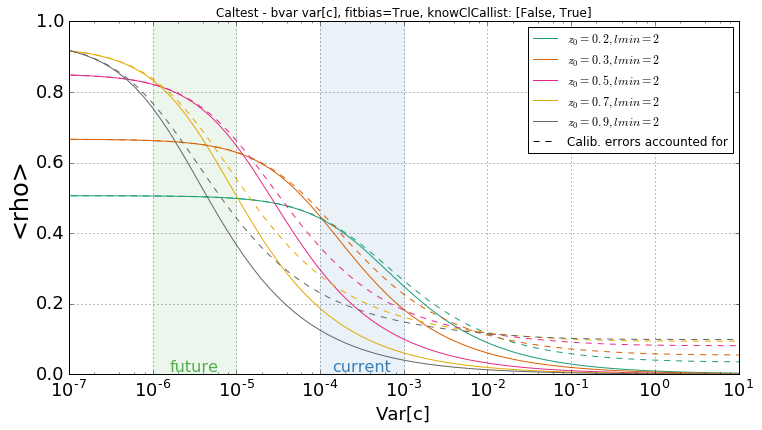

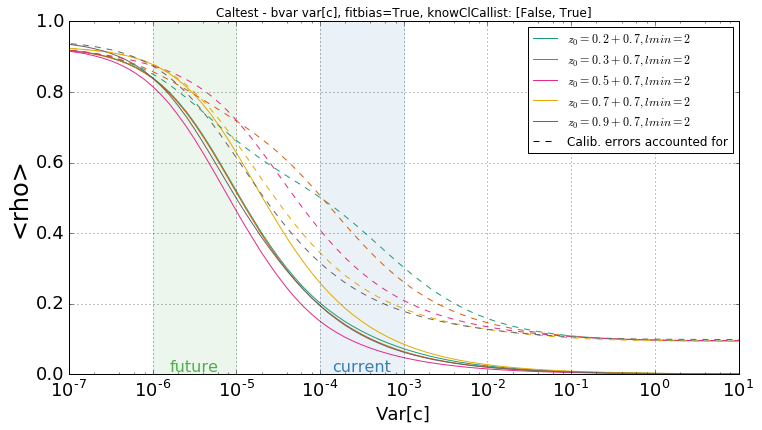

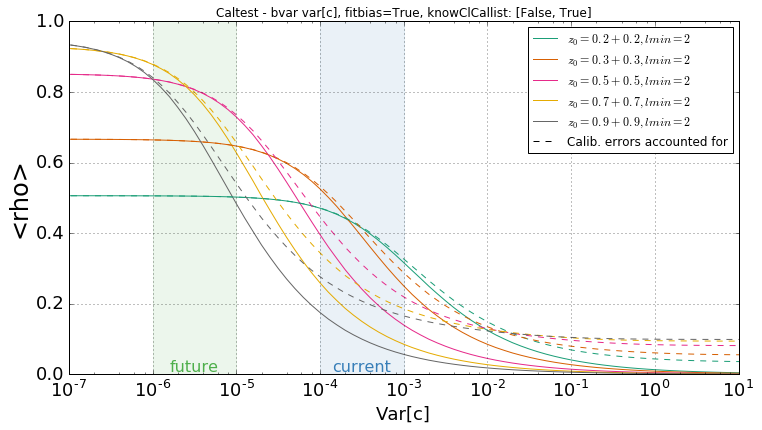

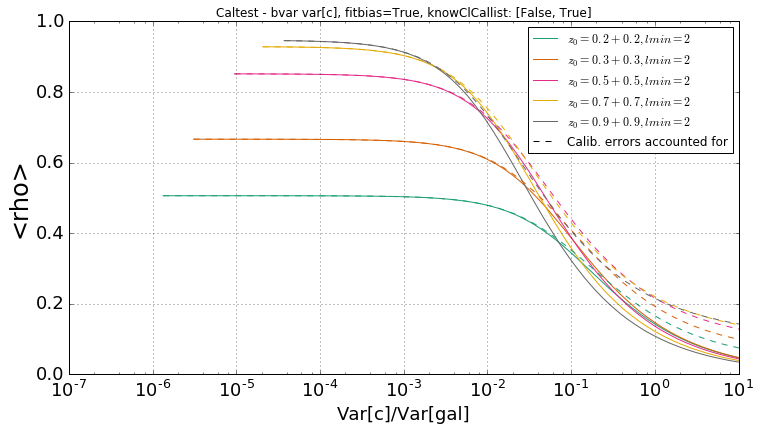

In [105]:
z0toplot=[.2,.3,.5,.7,.9]
print "\n-------single z0plots"
mcal_plot_many_z0(z0list=z0toplot,z0baselist=None, varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0)
print "\n-------plot paired with a fiducial z0=0.7 map"
mcal_plot_many_z0(z0list=z0toplot, z0baselist=[.7]*len(z0toplot), varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0)
print "\n-------plot double maps"
mcal_plot_many_z0(z0list=z0toplot, z0baselist=z0toplot, varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=False, doCross=0)
print "\n-------plot double maps"
mcal_plot_many_z0(z0list=z0toplot, z0baselist=z0toplot, varnamelist=['rho'], reclminlist=[2], nbar='default', fitbias=True, scaleToVarGal=True, doCross=0)

varlist
kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= False
Reading C_l file: output/depthtest/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.
  appending fiducial case, no calib error


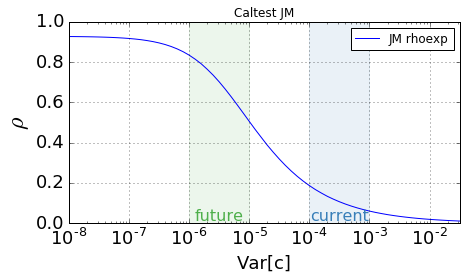

In [40]:
fig, ax1 = calplotsetup()
#test JM caltest to see if map crosspowers are being treated as correlated as well (seeing Cl_XY change with increasing var[c] even when X!=y for the multi tests)
rhoexplist=[]#will be 1D; [variance ] 
rhoexplist=runeuc.caltest_get_rhoexp(varlist=varlist,lmax=lmaxcal,lmin=lmincal,shape=shape,width=width,overwrite=True,doplot=False,
                              saverho=False,varname=varname,reclmin=reclmin)
ax1.plot(varlist[:-1],rhoexplist[:-1],'-',label='JM rhoexp')
ax1=calplotform(ax1,varname='rho') #format like caltest plot
plt.title('Caltest JM'.format(z0_base,bvlabel))
plt.show()

kmin=1.000e-05, kmax=1.000e+01, kperlog=300, krcut(add,mult)=(50,20);
in getCL, DoNotOverwrite= True
Reading C_l file: output/mCal02/Cl_output/Cl_depthtest.dat
    Using previously computed auto-corr.


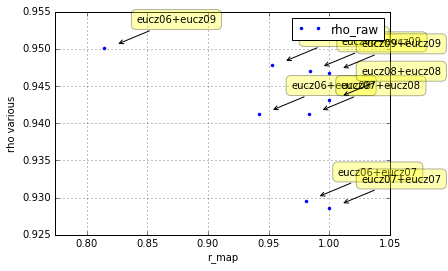

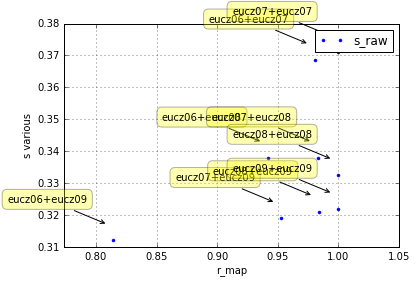

[0.98057756360748494, 0.94207674912818418, 0.81439990733924572, 1.0, 0.98306990825013585, 0.95290144728537274, 1.0, 0.98397906008392622, 1.0]

Nmaps: [1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]

Maps to include:
[['eucz03_bin0'], ['eucz06_bin0'], ['eucz07_bin0'], ['eucz08_bin0'], ['eucz09_bin0'], ['eucz06_bin0', 'eucz07_bin0'], ['eucz06_bin0', 'eucz08_bin0'], ['eucz06_bin0', 'eucz09_bin0'], ['eucz07_bin0', 'eucz07_bin0'], ['eucz07_bin0', 'eucz08_bin0'], ['eucz07_bin0', 'eucz09_bin0'], ['eucz08_bin0', 'eucz08_bin0'], ['eucz08_bin0', 'eucz09_bin0'], ['eucz09_bin0', 'eucz09_bin0']]
['isw_bin0', 'eucz03_bin0', 'eucz05_bin0', 'eucz06_bin0', 'eucz07_bin0', 'eucz08_bin0', 'eucz09_bin0']


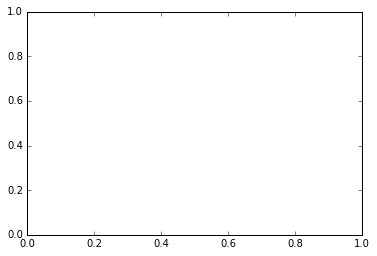

In [41]:
def m_z0toid(multi_list, z0_list):
    """convert a multi_list containing z0 values into one with indices of those values in z0_list, for input into multi_depthtest_get_reclist.
    e.g. m_z0toid([0.5,0.6,(.5,.6)], [0.3,0.4,0.5,0.6]) --> [2, 3, (2,3)]"""
    z0_list=list(z0_list)
    id_mult=[]
    for m in multi_list:
        if type(m)==tuple or type(m)==list:
            rtup=[]
            for z in m:
                rtup.append(z0_list.index(z))
            id_mult.append(tuple(rtup))
        else: id_mult.append(z0_list.index(m))
    return id_mult
            
depthtestz0=np.array([.3,.5,.6,.7,.8,.9])
nbar = 'default'
outtag='mCal02'
#rho_AB/(rho_a*rho_b) vs. r_AB
cldat=multi_get_Cl(justread=True,z0vals=depthtestz0, nbar=nbar, outtag=outtag)
#doMulti = getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
multi_z = [.3,.6,.7,.8,.9,(.6,.7),(.6,.8),(.6,.9),(.7,.7),(.7,.8),(.7,.9),(.8,.8),(.8,.9),(.9,.9)] #getCombos(range(len(depthtestz0))) #list of z0val map indices to combine for reconstruction.
reclist = multi_depthtest_get_reclist(depthtestz0, multi=m_z0toid(multi_z,depthtestz0), nbar=nbar)
mrs = [MRecStats(cldat, rec, use_nbar_in_r=True) for rec in reclist]

plot_mrslist(mrs, vartypes=['raw'],title=False, fitdeg=0, labplot=True)

print "\nNmaps:",[recdat.Nmap for recdat in reclist]
print "\nMaps to include:\n",[recdat.includeglm for recdat in reclist]
# rhopred = multi_depthtest_get_expected_rho(cldat=cldat,reclist=reclist,varname='rho')
print cldat.bintaglist

In [42]:
print(rpred)
N = len(rpred)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, rpred, width, color='r')
# add some text for labels, title and axes ticks
ax.set_ylabel('rpred')
#ax.set_title('Scores by group and gender')
ax.set_xticks(ind + width)
ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5'))
plt.show()

NameError: name 'rpred' is not defined

In [ ]:
if 1: #generate MULTI depthhtest maps (don't want togr)
    Nreal=100
    simmaps=True #do you want to simulate maps, or just do reconstructions (on maps that already exist?
    z0vals=depthtestz0

    doMulti = range(len(depthtestz0)) + [(0,1),(0,2),(2,3),(0,1,2),(0,1,2,3)] #list of z0val maps to combine for reconstruction.

    #z0vals=np.array([0.7])
    if simmaps: #generate maps and do reconstructions
        multi_depthtest_get_glm_and_rec(Nreal=Nreal,z0vals=z0vals,justgetrho=False,minreal=0,dorho=1,dos=True,dochisq=False,dorell=0,dochisqell=False, multi=doMulti, outtag=outtag)
    else: #do recs based on existing galaxy maps
        runeuc.depthtest_iswrec(Nreal,z0vals=z0vals,minreal=0,dorho=1,dos=1,domaps=True, multi=doMulti, outtag=outtag)
        #note, if you just want t compute rho but don't want to redo isw recs
        # change domaps to False

if 0: #plot info about depthtest maps, assumes you've already done isw recs
    for r in xrange(10,20):
         #depthtest_TTscatter(r,depthtestz0,savepngmaps=False)
         pass
    for N in 1000*np.arange(1,10): #how much do results change with Nreal
        #depthtest_plot_rhohist(depthtestz0,varname='rho',firstNreal=1000,startrealat=N)
        pass
    depthtest_plot_rhohist(depthtestz0,varname='rho')
    depthtest_plot_rhohist(depthtestz0,varname='s')
    depthtest_TTscatter(13,depthtestz0,savepngmaps=True)